In [1]:
# import stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
from scipy import signal
import h5py, time
from iminuit import Minuit, describe
from pprint import pprint # we use this to pretty print some stuff later

import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import load_dir

In [2]:
def shift_correct(input_pos,idx):
    output_pos = np.insert(input_pos,0,np.linspace(0,0,idx))
    return output_pos

def gaussian(data_x,params=list):
    norm = (1/((1/2*params[2])*np.sqrt(np.pi * 2)))
    return params[0] * norm * np.exp(-(np.subtract(data_x,params[1])**2/(2*params[2]**2)))+params[3]

def gaussian_cdf(data_x,params=list):
    # for normalization a 1/sigma could be needed
    return params[0]*0.5*(1+scipy.special.erf((data_x-params[1])/(np.sqrt(2)*params[2])))+params[3]

def linear(data_x,params=list):
    return params[0]*data_x+params[1]

def chisquare_1d(function, functionparams, data_x, data_y,data_y_error):
    chisquarevalue=np.sum(np.power(np.divide(np.subtract(function(data_x,functionparams),data_y),data_y_error),2))
    ndf = len(data_y)-len(functionparams)
    #print(ndf)
    return (chisquarevalue, ndf)

def chisquare_linear(a,b):
    return chisquare_1d(function=linear,functionparams=[a,b],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]

def chisquare_gaussian(area,mean,sigma,constant):
    return chisquare_1d(function=gaussian,functionparams=[area,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]

def chisquare_gaussian_cdf(amp,mean,sigma,constant):
    return chisquare_1d(function=gaussian_cdf,functionparams=[amp,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]

------------------------------------------------------------------
| FCN = 1.815                   |      Ncalls=35 (35 total)      |
| EDM = 1.22E-11 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
0.019834000085488412 -0.0015000315197539749


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: InitialParamWarning: Parameter b is floating but does not have initial step size. Assume 1.
  # This is added back by InteractiveShellApp.init_path()


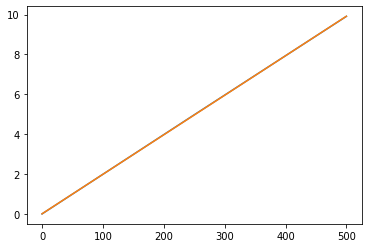

In [3]:
pos_list=np.asarray([-0.007,4.968,9.91])
y_err=np.asarray([0.01,0.01,0.01])
val = np.asarray([0,250,500])
data_x=val
data_y=pos_list
data_y_error=y_err
m2=Minuit(chisquare_linear, 
     a = 100,
     b=0,
     errordef = 1,
     print_level=1)

m2.migrad()

print(m2.values["a"],m2.values["b"])
plt.plot(val,pos_list)
plt.plot(val,m2.values["a"]*val+m2.values["b"])

In [4]:
# calibration of the voltage - position conversion

def voltage_to_position(voltage,slope=0.019834000085488412,offset=-0.0015000315197539749,redo=False):
    if(redo==True):
        pos_list=np.asarray([-0.007,4.968,9.91])
        y_err=np.asarray([0.01,0.01,0.01])
        val = np.asarray([0,250,500])
        data_x=val
        data_y=pos_list
        data_y_error=y_err
        m2=Minuit(chisquare_linear, 
             a = 100,
             b=0,
             errordef = 1,
             print_level=1)
        m2.migrad()
        print(m2.values["a"],m2.values["b"])
        plt.plot(val,pos_list,marker="*")
        plt.plot(val,m2.values["a"]*val+m2.values["b"])
        slope = m2.values["a"]
        offset = m2.values["b"]
    position=(voltage-offset)/slope
    return position

In [96]:
# load the data
Day = "11"
Month = "06"
Year = "2020"
BeadNumber = 3
#RunNumber = 144
folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day +"/Bead"+str(BeadNumber)+"/Shaking/"
#folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day +"/NoBead"+"/Shaking/"
#folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day + "/BeamProfile/"
files = load_dir(folder, file_prefix = 'BeamProfileX1_', max_file=500)
pos_x = files[0].cant_pos[0]
pos_y = files[0].cant_pos[1]
pos_z = files[0].cant_pos[2]
quad_sum = files[0].quad_sum


1  files in folder
1  files loaded


In [100]:
#Beam Profile for X with QPD
def get_average_mean_position(file_list):
    position_list = []
    sigma_list=[]
    def chisquare_gaussian_cdf(amp,mean,sigma,constant):
        return chisquare_1d(function=gaussian_cdf,functionparams=[amp,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
    
    for i in np.arange(0,len(file_list),1):#len(file_list),1):
        print(i)
        data_x = file_list[i].cant_pos[0] # give x data
        data_y = file_list[i].quad_sum# give y data 
        data_y_error = np.sqrt(np.abs(data_y)) # give y uncertainty  
        m=Minuit(chisquare_gaussian_cdf, 
         amp = -1.75e9, # set start parameter
         #limit_area= (limit_lower,limit_upper) # if you want to limit things
         #limit_amp = (1.5e-9,1.8e-9), # you can also fix it
         mean = 80.0,
         #fix_mean = "True",
         #limit_mean = (3500,4500),
         sigma = 5e-1,
         limit_sigma=(0,1),        
         constant = 1e8, #-1638000000, #739889080,
         #fix_constant="True",
         errordef = 1,
         print_level=0,pedantic=False)
         #print('Now proceed with the fit.')
        m.migrad(ncall=500000)
        print(m.values["amp"])
        position_list.append(voltage_to_position(m.values["mean"]))
        sigma_list.append(m.values["sigma"])
        plt.plot(voltage_to_position(data_x),data_y)
        #plt.yscale("log")
        plt.plot(voltage_to_position(data_x),gaussian_cdf(data_x,params=[m.values["amp"],(m.values["mean"]),m.values["sigma"],m.values["constant"]]),alpha=1)
        plt.show() 
    return position_list,np.mean(position_list),np.std(position_list),sigma_list


0
-1662077685.550172


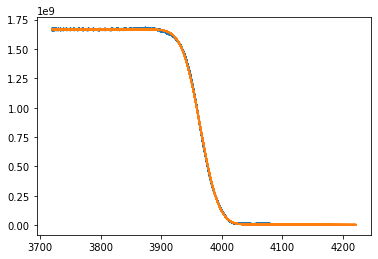

In [101]:
fit = get_average_mean_position(files)

In [99]:
fit.values

<ValueView of Minuit at 826d088>
  amp: -1662077685.550172
  mean: 78.631595613861
  sigma: 0.4724849677670575
  constant: 1666716544.2074976

In [102]:
np.divide(fit[0],10)

array([396.45606185])

In [77]:
print(fit)

([3964.560618456023], 3964.560618456023, 0.0, [0.4724849677670575])


In [112]:
#Beam Profile for X with spin
def get_average_mean_position(file_list):
    position_list = []
    sigma_list=[]
    def chisquare_gaussian_cdf(amp,mean,sigma,constant):
        return chisquare_1d(function=gaussian_cdf,functionparams=[amp,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
    
    for i in np.arange(0,len(file_list),1):#len(file_list),1):
        print(i)
        data_x = file_list[i].cant_pos[0] # give x data
        data_y = file_list[i].spin_data # give y data 
        data_y_error = np.sqrt(np.abs(data_y)) # give y uncertainty  
        m=Minuit(chisquare_gaussian_cdf, 
         amp = -1, # set start parameter
         #limit_area= (limit_lower,limit_upper) # if you want to limit things
         #limit_amp = (-3e-9,-1.5e-9), # you can also fix it
         mean = 7.9,
         #fix_mean = "True",
         #limit_mean = (3500,4500),
         sigma = 0.3e-1,
         limit_sigma=(0,1),        
         constant = 0,
         #fix_constant="True",
         errordef = 1,
         print_level=0,pedantic=False)
         #print('Now proceed with the fit.')
        m.migrad(ncall=500000)
        print(m.values["amp"])
        position_list.append(voltage_to_position(m.values["mean"]))
        sigma_list.append(m.values["sigma"])
        plt.plot(voltage_to_position(data_x),data_y)
        #plt.yscale("log")
        plt.plot(voltage_to_position(data_x),gaussian_cdf(data_x,params=[m.values["amp"],(m.values["mean"]),m.values["sigma"],m.values["constant"]]),alpha=1)
        plt.show() 
    return position_list,np.mean(position_list),np.std(position_list),sigma_list


In [113]:
fit = get_average_mean_position(files)

0


RuntimeError: exception was raised in user function
User function arguments:
         amp = -1.000000
        mean = +7.900000
       sigma = +0.030000
    constant = +0.000000
Original python exception in user function:
ValueError: operands could not be broadcast together with shapes (50000,) (500000,) 
  File "<ipython-input-112-6c4328b6cd87>", line 6, in chisquare_gaussian_cdf
    return chisquare_1d(function=gaussian_cdf,functionparams=[amp,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
  File "<ipython-input-2-b07e1fc0cc81>", line 17, in chisquare_1d
    chisquarevalue=np.sum(np.power(np.divide(np.subtract(function(data_x,functionparams),data_y),data_y_error),2))


In [114]:
fit[0]

[403.423414189358]

In [105]:
# load the data for y
Day = "11"
Month = "06"
Year = "2020"
BeadNumber = 3
#RunNumber = 144
folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day +"/Bead"+str(BeadNumber)+"/Shaking/"
#folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day +"/NoBead"+"/Shaking/"
#folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day + "/BeamProfile/"
files = load_dir(folder, file_prefix = 'BeamProfileY1_', max_file=500)
pos_x = files[0].cant_pos[0]
pos_y = files[0].cant_pos[1]
pos_z = files[0].cant_pos[2]
quad_sum = files[0].quad_sum


1  files in folder
1  files loaded


In [111]:
#Beam Profile for Y with QPD
def get_average_mean_position(file_list):
    position_list = []
    sigma_list=[]
    def chisquare_gaussian_cdf(amp,mean,sigma,constant):
        return chisquare_1d(function=gaussian_cdf,functionparams=[amp,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
    
    for i in np.arange(0,len(file_list),1):#len(file_list),1):
        print(i)
        data_x = file_list[i].cant_pos[1] # give x data
        data_y = file_list[i].quad_sum# give y data 
        data_y_error = np.sqrt(np.abs(data_y)) # give y uncertainty  
        m=Minuit(chisquare_gaussian_cdf, 
         amp = 1.8e9, # set start parameter
         #limit_area= (limit_lower,limit_upper) # if you want to limit things
         #limit_amp = (-3e-9,-1.5e-9), # you can also fix it
         mean = 79,
         #fix_mean = "True",
         #limit_mean = (3500,4500),
         sigma = 3e-1,
         limit_sigma=(0,1),        
         constant = 739889080,
         #fix_constant="True",
         errordef = 1,
         print_level=0,pedantic=False)
         #print('Now proceed with the fit.')
        m.migrad(ncall=500000)
        print(m.values["amp"])
        position_list.append(voltage_to_position(m.values["mean"]))
        sigma_list.append(m.values["sigma"])
        plt.plot(voltage_to_position(data_x),data_y)
        #plt.yscale("log")
        plt.plot(voltage_to_position(data_x),gaussian_cdf(data_x,params=[m.values["amp"],(m.values["mean"]),m.values["sigma"],m.values["constant"]]),alpha=1)
        plt.show() 
    return position_list,np.mean(position_list),np.std(position_list),sigma_list


0
1671158606.6588962


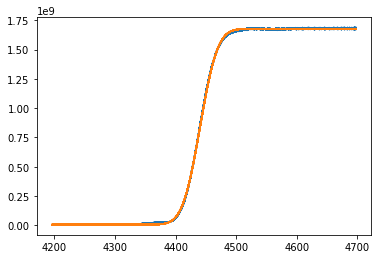

In [112]:
fit = get_average_mean_position(files)

In [115]:
np.divide(fit[0],10)

array([444.03730437])

In [27]:
#Beam Profile for X with spin
def get_average_mean_position(file_list):
    position_list = []
    sigma_list=[]
    def chisquare_gaussian_cdf(amp,mean,sigma,constant):
        return chisquare_1d(function=gaussian_cdf,functionparams=[amp,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
    
    for i in np.arange(0,len(file_list),1):#len(file_list),1):
        print(i)
        data_x = file_list[i].cant_pos[1] # give x data
        data_y = file_list[i].spin_data # give y data 
        data_y_error = np.sqrt(np.abs(data_y)) # give y uncertainty  
        m=Minuit(chisquare_gaussian_cdf, 
         amp = -1, # set start parameter
         #limit_area= (limit_lower,limit_upper) # if you want to limit things
         #limit_amp = (-3e-9,-1.5e-9), # you can also fix it
         mean = 7.9,
         #fix_mean = "True",
         #limit_mean = (3500,4500),
         sigma = 0.3e-1,
         limit_sigma=(0,1),        
         constant = 0,
         #fix_constant="True",
         errordef = 1,
         print_level=0,pedantic=False)
         #print('Now proceed with the fit.')
        m.migrad(ncall=500000)
        print(m.values["amp"])
        position_list.append(voltage_to_position(m.values["mean"]))
        sigma_list.append(m.values["sigma"])
        plt.plot(voltage_to_position(data_x),data_y)
        #plt.yscale("log")
        plt.plot(voltage_to_position(data_x),gaussian_cdf(data_x,params=[m.values["amp"],(m.values["mean"]),m.values["sigma"],m.values["constant"]]),alpha=1)
        plt.show() 
    return position_list,np.mean(position_list),np.std(position_list),sigma_list


0
-0.7671548221019258


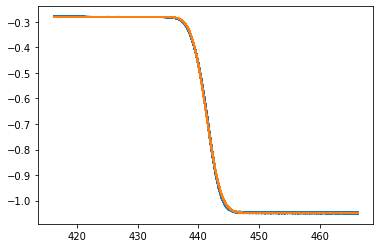

In [28]:
fit = get_average_mean_position(files)

In [29]:
fit[0]

[441.32959809208074]

In [42]:
a = [voltage_to_position(fit[3][i]) for i in np.arange(0,len(fit[3]),1)]

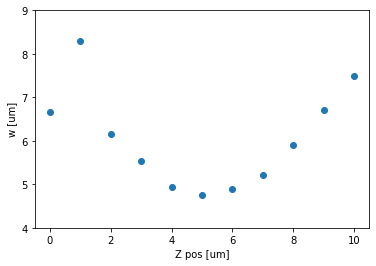

In [43]:
x=np.arange(0,len(a),1)
plt.plot(x,np.multiply(2,a), linestyle="",marker="o")
plt.ylim(4,9)
plt.xlabel("Z pos [um]")
plt.ylabel("w [um]")
plt.savefig("waist_20200225X2.png",dpi=300,bbox_inches="tight")

In [24]:
#Beam Profile for y
def get_average_mean_position(file_list):
    position_list = []
    sigma_list=[]
    def chisquare_gaussian_cdf(amp,mean,sigma,constant):
        return chisquare_1d(function=gaussian_cdf,functionparams=[amp,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
    
    for i in np.arange(0,len(file_list),1):#len(file_list),1):
        print(i)
        data_x = file_list[i].cant_pos[1] # give x data
        data_y = file_list[i].quad_sum# give y data 
        data_y_error = np.sqrt(np.abs(data_y)) # give y uncertainty  
        m=Minuit(chisquare_gaussian_cdf, 
         amp = 2.6e9, # set start parameter
         #limit_area= (limit_lower,limit_upper) # if you want to limit things
         #limit_amp = (-3e-9,-1.5e-9), # you can also fix it
         mean = 7.8,
         #fix_mean = "True",
         #limit_mean = (3500,4500),
         sigma = 0.3e-1,
         constant = 0.5e9,
         #fix_constant="True",
         errordef = 1,
         print_level=0,pedantic=False)
         #print('Now proceed with the fit.')
        m.migrad(ncall=500000)
        print(m.values["amp"])
        position_list.append(voltage_to_position(m.values["mean"]))
        sigma_list.append(m.values["sigma"])
        plt.plot(voltage_to_position(data_x),data_y)
        plt.plot(voltage_to_position(data_x),gaussian_cdf(data_x,params=[m.values["amp"],(m.values["mean"]),m.values["sigma"],m.values["constant"]]),alpha=1)
        plt.show() 
    return position_list,np.mean(position_list),np.std(position_list),sigma_list


In [25]:
get_average_mean_position(files[4:])

/home/analysis_user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/analysis_user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/analysis_user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/analysis_user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/analysis_user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


([], nan, nan, [])

In [135]:
a = [voltage_to_position(fit[3][i]) for i in np.arange(0,len(fit[3]),1)]

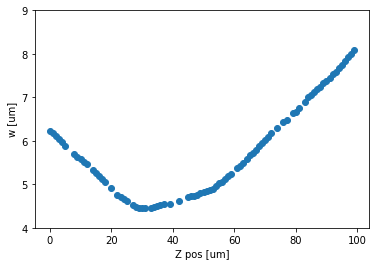

In [140]:
x=np.arange(0,len(a),1)
plt.plot(x,np.multiply(2,a), linestyle="",marker="o")
plt.ylim(4,9)
plt.xlabel("Z pos [um]")
plt.ylabel("w [um]")
plt.savefig("waist_20200225Y2.png",dpi=300,bbox_inches="tight")

In [139]:
[2*voltage_to_position(fit[3][i]) for i in np.arange(0,len(fit[3]),1)]

[6.229764403312514,
 6.172484570051346,
 6.109673148369922,
 6.040274364563224,
 5.967754731887021,
 5.88985006488405,
 75.14896298106888,
 0.5777545222774089,
 5.698320507858847,
 5.634590407701169,
 5.572100711289958,
 5.523991184006082,
 5.465681386473252,
 43.64787335951288,
 5.335331423639843,
 5.270645485178977,
 5.201152142679089,
 5.130095655561299,
 5.0547798380623945,
 29.16432583120394,
 4.906158508121886,
 32.3624167369887,
 4.754517727759273,
 4.715283300313966,
 4.6676946338027445,
 4.605733613969445,
 31.579325843458857,
 4.517277622479776,
 4.479719730803449,
 4.448503967086432,
 4.448698068975776,
 4.453070457214191,
 48.500422938331155,
 4.450705234524679,
 4.484094324459994,
 4.506686709822351,
 4.520173862159061,
 4.543643235498541,
 30.43226891566806,
 4.547373759964121,
 0.17349557930700849,
 1.2519675675496234,
 4.616275983807846,
 36.28375832867172,
 0.15815071246550957,
 4.699791971414087,
 4.721309937724405,
 4.720960493150219,
 4.76527908415997,
 4.8007604541

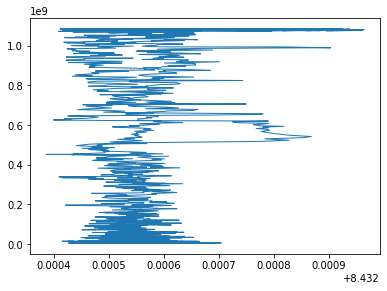

In [117]:
_,ax = plt.subplots()
plt.subplots_adjust(left=0.18, right=0.99, top=0.96, bottom=0.14)
ax.plot(pos_x,quad_sum, '-', label="x",markersize=1,linewidth=1)


In [ ]:
print(pos_x)

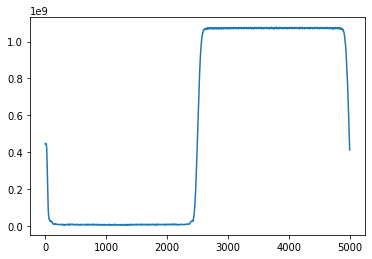

In [90]:
plt.plot(quad_sum)